In [6]:
import os, sys
import glob
import pandas as pd
import numpy as np
import scipy.special
import operator

from collections import Counter, defaultdict
from time import time
import datetime

import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

from bokeh.charts import Histogram, defaults, vplot, hplot, show, output_file

In [7]:
font = {'family' : 'monospace',
        'weight' : 'medium',
        'size'   : 24}

matplotlib.rc('font', **font)

In [8]:
today = str(datetime.date.today())

In [9]:
newpath = r'/home/rafa/github/For Businesses/Infinite-Agency/Results-From-{}/'.format(today)
if not os.path.exists(newpath):
    os.makedirs(newpath)

# Cleaning Functions

In [10]:
import glob
def make_big_frame():
    """
    big_frame is every .csv file stacked on top of one another from the directory
    
    path = full file path
    
    it also prints if the columns were of equal length
    """
    
    # pull each csv into a list
    dfs = []
    #insert path here
    #put in fullpath to file, and filetype = csv, txt, etc.
    path = "/home/rafa/github/For Businesses/Infinite-Agency/BG/*.csv" 
    count = 0
    for fname in glob.glob(path):
        count += 1
        print 'file number:{}'.format(count)
        dfs.append(pd.read_csv(fname, low_memory=False))
    
    # creates a set of their column lengths
    shape_set = set([df.shape[1] for df in dfs])
    big_frame = pd.concat(dfs, ignore_index = True, axis = 0)
    
    if len(shape_set) > 1:
        print 'Unequal Columns!'
    else:
        print 'Columns are equal length :)\n Shape = {}'.format(big_frame.shape)
 
    big_frame.dropna(axis = 1, how = 'all', inplace=True)
    drop_nonunique(big_frame)
    print 'concat is complete: shape = {}'.format(big_frame.shape)
    return big_frame

In [11]:
def make_datelist(big_frame):
    datelist = []
    for column in big_frame.columns:
        if 'Date' in column:
            datelist.append(column)
    return datelist

In [12]:
def change_date(big_frame, datelist):
    datelist = []
    for column in datelist:
        big_frame[column] = pd.to_datetime(big_frame[column], infer_datetime_format=False)
    return big_frame

In [13]:
def drop_nonConversions(big_frame, datelist):
    for column in datelist:
        if column != 'ConversionDate':
            big_frame.drop(column, axis=1, inplace=True)

In [14]:
def drop_nonunique(big_frame):
    for column in big_frame.columns:
        if len(big_frame[column].unique()) == 1:
            big_frame.drop(column, axis=1, inplace=True)
    print big_frame.shape

# Create frame and add new columns
-------------------------------

In [15]:
big_frame = make_big_frame()
big_frame.shape
datelist = make_datelist(big_frame)
drop_nonConversions(big_frame, datelist)
big_frame = change_date(big_frame, datelist)
big_frame.drop_duplicates(inplace = True, subset = ['ConversionID'])
big_frame.reset_index(inplace=True)
big_frame.shape

file number:1
file number:2
file number:3
file number:4
file number:5
file number:6
file number:7
file number:8
file number:9
file number:10
file number:11
file number:12
file number:13
file number:14
file number:15
file number:16
file number:17
file number:18
file number:19
file number:20
file number:21
file number:22
file number:23
file number:24
file number:25
file number:26
file number:27
file number:28
file number:29
Columns are equal length :)
 Shape = (3911, 4573)
(3911, 1087)
concat is complete: shape = (3911, 1087)


(419, 994)

In [16]:
natural_list = []
for column in big_frame.columns:
    if 'atural' in column:
        natural_list.append(column)

In [17]:
time_list = []
for datetimes in big_frame['ConversionDate']:
    time_list.append(int(datetimes[11:13]))

In [18]:
path_lst = []
for column in big_frame.columns:
    if 'PlacementID/SearchKeywordID' in column:
        path_lst.append(column)

In [19]:
paths_by_name = []
for row in range(big_frame.shape[0]):
    path_name = []
    for item in range(len(path_lst)):
        path_name.append(big_frame.loc[row, path_lst[item]])
    paths_by_name.append(path_name)

for index, path in enumerate(paths_by_name):
    paths_by_name[index] = [int(node) for node in path if node <= 300000000]

In [20]:
clean_paths = open(newpath + 'clean_paths-{}.txt'.format(today), 'w')
for i in paths_by_name:
    clean_paths.write('%s \n' %i)

In [21]:
path_lengths = [len(path) for path in paths_by_name]
big_frame['path_lengths'] = path_lengths
big_frame['paths_by_adname'] = paths_by_name
big_frame['hour'] = time_list

In [22]:
big_frame.to_csv(newpath + 'big_frame-{}.csv'.format(today))

# Make new frames

In [23]:
state_list = big_frame['State-Region'].unique()
new_frame = big_frame[['ConversionID','BrowserType', 'OperatingSystemType', 'DeviceType','path_lengths', 'paths_by_adname', 'State-Region', 'hour']]
smaller_frames = []
for states in state_list:
    smaller_frames.append(new_frame[new_frame['State-Region'] == states])
    
after_hours = new_frame[(new_frame['hour'] < 10) | (new_frame['hour'] > 22)].sort_values(by = ['path_lengths'])
during_hours = new_frame[(new_frame['hour'] > 10) & (new_frame['hour'] < 22)].sort_values(by = ['path_lengths'])

new_frame['hour'].count()

419

# Plot time of day histograms

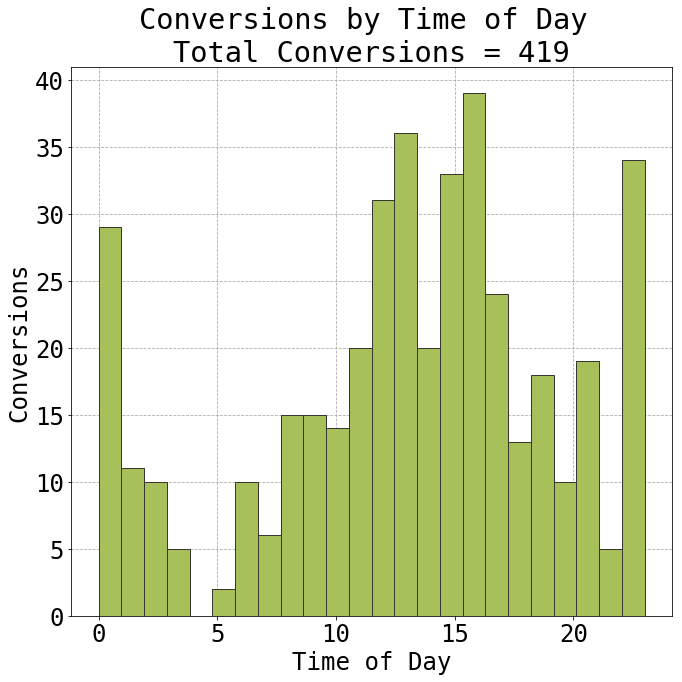

In [24]:
fonts = 24
f, (ax0) = plt.subplots(1, 1, figsize = (10, 10))

ax0.grid(zorder = 0, linestyle = 'dashed', color = '#acaaa8')
ax0.hist(new_frame['hour'], bins = 24, color = '#a7c059', zorder = 3, histtype='bar', ec='#383632')
ax0.set_title('Conversions by Time of Day \nTotal Conversions = {}'.format(new_frame.shape[0]))
ax0.set_xlabel('Time of Day', fontsize = fonts)
ax0.set_ylabel('Conversions', fontsize = fonts)

# ax1.grid(zorder = 0, linestyle = 'dashed', color = '#acaaa8')
# ax1.hist(after_hours['hour'], bins = 24, color = '#a7c059', zorder = 3)
# ax1.set_title('Between 10 pm and 10 am\nTotal Conversions = {}'.format(after_hours.shape[0]))
# ax1.set_xlabel('Time of Day', fontsize = fonts)
# ax1.set_ylabel('Conversions', fontsize = fonts)


# ax2.grid(zorder = 0, linestyle = 'dashed', color = '#acaaa8')
# ax2.hist(during_hours['hour'], bins = 24, color = '#a7c059', zorder = 3)
# ax2.set_title('Between 10 pm and 10 am\n Total Conversions = {}'.format(during_hours.shape[0]))
# ax2.set_xlabel('Time of Day', fontsize = fonts)
# ax2.set_ylabel('Conversions', fontsize = fonts)

plt.tight_layout()
plt.savefig(newpath + 'ConversionsTimeOfDay-{}.png'.format(today))
plt.show()

In [25]:
optimal = new_frame[new_frame['path_lengths'] < 31]
optimal = optimal.sort_values(by = 'path_lengths')

In [29]:
ad_list = []
for path_name in optimal['paths_by_adname']:
    for ad in path_name:
        if ad not in ad_list:
            ad_list.append(ad)
            
vals = [0] * len(ad_list)
ads = dict(zip(ad_list, vals))
for different_paths in optimal['paths_by_adname']:
    for ad in different_paths:
        ads[ad] += 1
        
ads = sorted(ads.items(), key = operator.itemgetter(1))[::-1]
xvalues = range(1, len(ads) + 1)
yvalues = [ad[1] for ad in ads]
names = [str(ad[0]) for ad in ads]

sums = []
for index in range(len(yvalues)):
    sums.append(sum(yvalues[0:index]))
    
disp_avg = sum([ad[1] for ad in ads])/float(len(ads))
disp_avg

144.16666666666666

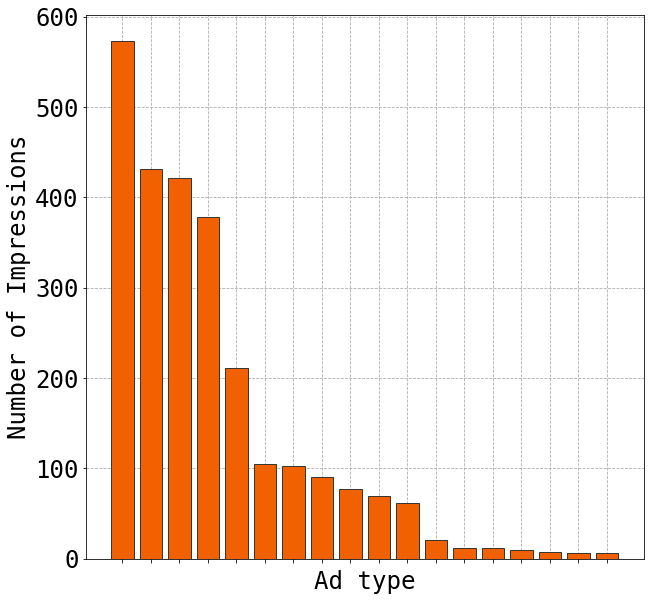

In [34]:
fig, ax = plt.subplots(figsize = (10, 10))
plt.grid(zorder = 0, linestyle = 'dashed', color = '#acaaa8')


ax = plt.bar(xvalues, 
             yvalues,
             ec='#383632',
             color='#F26101', 
             zorder = 3)

# plt.axhline(y = disp_avg, 
#             zorder = 3, 
#             color = '#383632', 
#             linestyle = 'dashed', 
#             label = 'Avg Impressions({})'.format(round(disp_avg, 0)))

plt.ylabel('Number of Impressions')
# plt.xlabel('Ad Type')
plt.xlabel('Ad type')
plt.xticks(xvalues, ['']*len(xvalues), 
           rotation = 90)


plt.legend()
plt.savefig(newpath + 'AdImpressions-Conversions_TAGID-{}.png'.format(today))
plt.show()

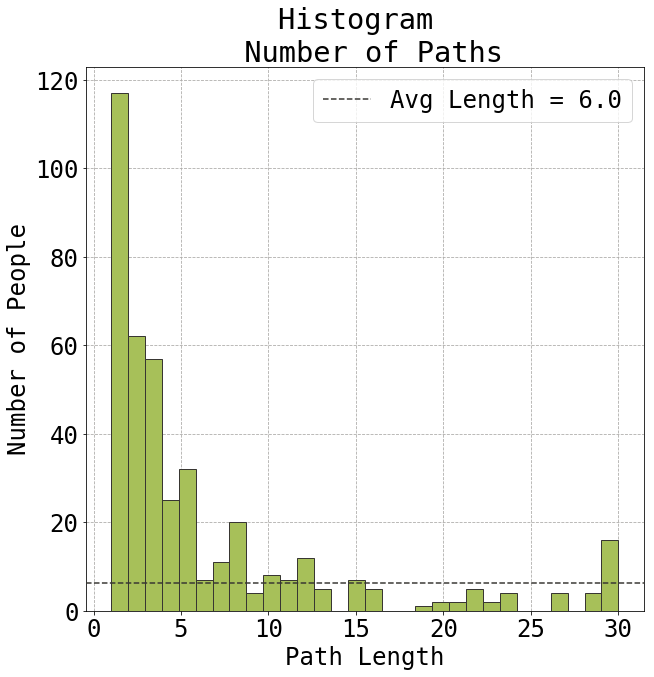

In [31]:
f, (ax0) = plt.subplots(1, 1, figsize = (10, 10))

ax0.grid(zorder = 0, linestyle = 'dashed', color = '#acaaa8')
ax0.hist(big_frame['path_lengths'], 
         bins = 30, 
         color = '#a7c059', 
         zorder = 3, 
         histtype='bar', 
         ec='#383632', 
         label = '')


ax0.set_title('Histogram \n Number of Paths')
ax0.set_xlabel('Path Length', fontsize = fonts)
ax0.set_ylabel('Number of People', fontsize = fonts)


plt.axhline(y = big_frame['path_lengths'].mean(), 
            zorder = 3, 
            color = '#383632', 
            linestyle = 'dashed', 
            label = 'Avg Length = {}'.format(round(big_frame['path_lengths'].mean(), 0)))

plt.legend()
plt.savefig(newpath + 'PathLengths-{}.png'.format(today))

In [24]:
optimal_list = []
for lengths in optimal['path_lengths'].unique():
    df = optimal[optimal['path_lengths'] == lengths]
    optimal_list.append(df)

In [25]:
count_paths = Counter()
for paths in optimal['paths_by_adname']:
    count_paths[str(paths)] += 1
    
count_paths = sorted(count_paths.items(), key = operator.itemgetter(1))[::-1]

In [26]:
pathfile = open(newpath + 'paths-{}.txt'.format(today), 'w')
pathfile.write('Paths - People Who Took Path \n')
pathfile.write('-------------------------------\n')
for item in count_paths:
    newitem = str(item[1]) + ' people :' + item[0]
    pathfile.write('%s \n' %newitem)

In [27]:
path_frame_list = ['ConversionID']
path_frame_list += path_lst

In [28]:
path_frame = big_frame[path_frame_list]
path_frame.fillna(value = 0)
path_frame.to_csv(newpath + 'AttributionsOnly-{}.csv'.format(today))

In [29]:
optimal.reset_index(inplace=True, drop=True)
cleaned = optimal.copy()

In [30]:
cleaned.to_csv(newpath + 'cleaned-{}.csv'.format(today))

In [31]:
state_count = Counter()
for state in cleaned['State-Region']:
    state_count[state] += 1

In [32]:
avg_state = np.mean(state_count.values())
avg_state

17.458333333333332

In [33]:
state_count = sorted(state_count.items(), key = operator.itemgetter(1))[::-1]

In [34]:
xvalues = range(1, len(state_count) + 1)
yvalues = [state[1] for state in state_count]
names = [str(state[0]) for state in state_count]

print xvalues
print yvalues
print names

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]
[184, 99, 38, 17, 14, 10, 7, 6, 5, 5, 5, 4, 3, 3, 3, 3, 2, 2, 2, 2, 2, 1, 1, 1]
['Washington', 'Minnesota', 'California', 'Wisconsin', 'Georgia', 'Texas', 'Illinois', 'Massachusetts', 'North Carolina', 'Pennsylvania', 'New York', 'Tennessee', 'New Hampshire', 'Oregon', 'Maryland', 'Indiana', 'North Dakota', 'Connecticut', 'Utah', 'Michigan', 'Arizona', 'Ohio', 'Florida', 'Arkansas']


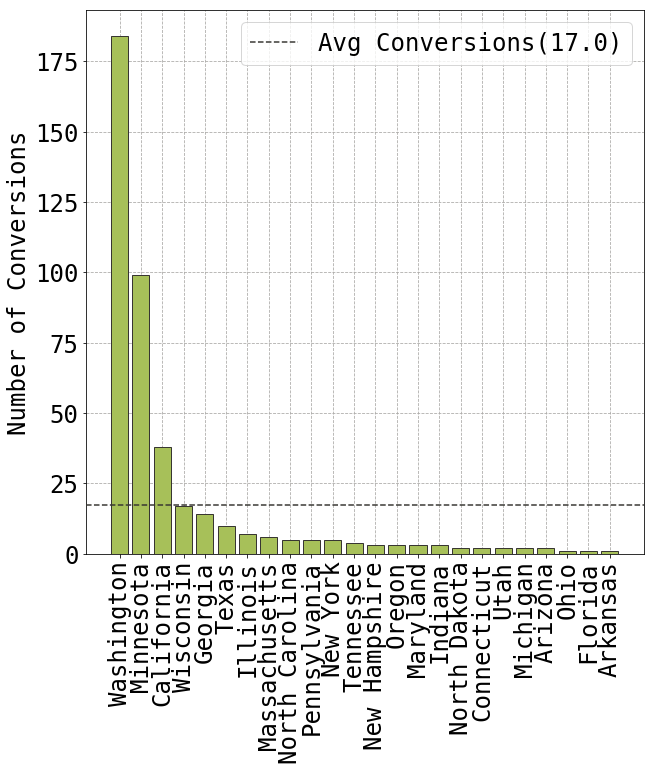

In [35]:
fig, ax = plt.subplots(figsize = (10, 10))
plt.grid(zorder = 0, linestyle = 'dashed', color = '#acaaa8')


ax = plt.bar(xvalues, 
             yvalues,
             ec='#383632',
             color='#a7c059', 
             zorder = 3)

plt.axhline(y = avg_state, 
            zorder = 3, 
            color = '#383632', 
            linestyle = 'dashed', 
            label = 'Avg Conversions({})'.format(round(avg_state, 0)))

plt.ylabel('Number of Conversions')
# plt.xlabel('Ad Type')

plt.xticks(xvalues, 
           names, 
           rotation = 90)


plt.legend()
plt.savefig(newpath + 'Conversions by DMA-{}.png'.format(today))
plt.show()